In [164]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

from collections import deque
from sklearn.model_selection import train_test_split

import tensorflow as tf 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model, Sequence

import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Utils

In [165]:
# plot training history function
def plot_training_history(history):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, 3])
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [166]:
DIR_PATH = "./RWF-2000-LIGHT"
TRAIN_DIR = os.path.join(DIR_PATH, "train")
TEST_DIR = os.path.join(DIR_PATH, "val")

In [167]:
CLASS_NAMES = os.listdir(TRAIN_DIR)
SEED = 1337
SEQUENCE_LENGTH  = 30
IMG_HEIGHT = 64
IMG_WIDTH = 64
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
BATCH_SIZE = 32

VALIDATION_SPLIT = 0.2

In [168]:
# get list of labels and video path
def get_labels_and_video_paths(data_dir):
    labels = []
    video_paths = []
    for label in CLASS_NAMES:
        label_dir = os.path.join(data_dir, label)
        for video in os.listdir(label_dir):
            video_paths.append(os.path.join(label_dir, video))
            labels.append(label)
    return labels, video_paths

## Load Data

In [169]:
class VideoDataGenerator(Sequence):
    def __init__(self, video_paths, labels, batch_size, num_frames, img_size, shuffle=True):
        """Initializes the video generator."""
        self.video_paths = video_paths
        self.labels = labels
        self.batch_size = batch_size
        self.num_frames = num_frames
        self.img_size = img_size  # (height, width)
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.video_paths))
        self.on_epoch_end()  # Shuffle data at the start

    def on_epoch_end(self):
        """Shuffle the data at the end of each epoch if shuffle is set to True."""
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        """Return the number of batches per epoch."""
        return len(self.video_paths) // self.batch_size

    def __getitem__(self, index):
        """Generate one batch of data."""
        # Get batch indexes
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Get batch video paths and labels
        batch_video_paths = [self.video_paths[i] for i in batch_indexes]
        batch_labels = [self.labels[i] for i in batch_indexes]

        # Generate data
        X, y = self.__data_generation(batch_video_paths, batch_labels)

        return X, y

    def __data_generation(self, batch_video_paths, batch_labels):
        """Generate data containing batch_size samples."""
        X = np.empty((self.batch_size, self.num_frames - 1, *self.img_size, 3))  # Create a batch of empty arrays
        y = np.empty((self.batch_size), dtype=int)

        for i, video_path in enumerate(batch_video_paths):
            frames = self.load_video_frames(video_path)
            X[i,] = frames  # Assign video frames to batch
            y[i] = batch_labels[i]  # Assign corresponding label

        return X, np.array(y)

    def load_video_frames(self, video_path):
        """Load and preprocess a fixed number of frames from a video file."""
        cap = cv2.VideoCapture(video_path)
        frames = []
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Calculate step size to sample frames evenly
        step = max(frame_count // self.num_frames, 1)

        prev_frame = None
        for i in range(0, frame_count, step):
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, self.img_size)  # Resize to img_size
            frame = frame / 255.0  # Normalize frame

            if prev_frame is not None:
                frame_diff = cv2.absdiff(prev_frame, frame)
                frames.append(frame_diff)

            prev_frame = frame

            if len(frames) == self.num_frames - 1:
                break

        cap.release()

        # If fewer frames than expected, pad with zeros
        while len(frames) < self.num_frames - 1:
            frames.append(np.zeros((*self.img_size, 3)))

        return np.array(frames)


In [170]:
# get labels and video path
labels, video_paths = get_labels_and_video_paths(TRAIN_DIR)
labels_test, video_paths_test = get_labels_and_video_paths(TEST_DIR)

# encode the labels 
label_encoder = LabelEncoder()

labels = label_encoder.fit_transform(labels)
labels_test = label_encoder.transform(labels_test)

train_video_paths, val_video_paths, train_labels, val_labels = train_test_split(
    video_paths, labels, test_size=VALIDATION_SPLIT, random_state=42, stratify=labels
)

# generate data
train_gen = VideoDataGenerator(train_video_paths, train_labels, BATCH_SIZE, SEQUENCE_LENGTH, IMG_SIZE)
val_gen = VideoDataGenerator(val_video_paths, val_labels, BATCH_SIZE, SEQUENCE_LENGTH, IMG_SIZE)
test_gen = VideoDataGenerator(video_paths_test, labels_test, BATCH_SIZE, SEQUENCE_LENGTH, IMG_SIZE)

# Training Model

In [171]:
def create_convlstm_model():
    model = Sequential()
    
    model.add(layers.ConvLSTM2D(
        filters=4,
        kernel_size=(3, 3),
        padding='same',
        input_shape=(SEQUENCE_LENGTH - 1, IMG_HEIGHT, IMG_WIDTH, 3),
        return_sequences=True,
        recurrent_dropout=0.2,
        data_format='channels_last'
        )
    )
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling3D(pool_size=(1, 2, 2), padding = 'same', data_format='channels_last'))
    model.add(layers.TimeDistributed(layers.Dropout(0.2)))
    
    
    model.add(layers.ConvLSTM2D(
        filters=8,
        kernel_size=(3, 3),
        padding='same',
        input_shape=(SEQUENCE_LENGTH - 1, IMG_HEIGHT, IMG_WIDTH, 3),
        return_sequences=True,
        recurrent_dropout=0.2,
        data_format='channels_last'
        )
    )
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling3D(pool_size=(1, 2, 2), padding = 'same', data_format='channels_last'))
    model.add(layers.TimeDistributed(layers.Dropout(0.2)))
    
    model.add(layers.ConvLSTM2D(
        filters=16,
        kernel_size=(3, 3),
        padding='same',
        input_shape=(SEQUENCE_LENGTH - 1, IMG_HEIGHT, IMG_WIDTH, 3),
        return_sequences=True,
        recurrent_dropout=0.2,
        data_format='channels_last'
        )
    )
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling3D(pool_size=(1, 2, 2), padding = 'same', data_format='channels_last'))
    model.add(layers.TimeDistributed(layers.Dropout(0.2)))
    
    
    
    # Last layer: 3D Convolution for final spatio-temporal feature extraction
    model.add(layers.Conv3D(filters=1, kernel_size=(3, 3, 3), activation='sigmoid', padding='same'))

        
    # classifier
    model.add(layers.Flatten())
    model.add(layers.Dense(len(CLASS_NAMES), activation='sigmoid'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    model.summary()
    
    return model
    
conv_lstm = create_convlstm_model()

c:\Users\erick\miniconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d_36 (ConvLSTM2D)     │ (None, 29, 64, 64, 4)  │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 29, 64, 64, 4)  │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_36 (MaxPooling3D) │ (None, 29, 32, 32, 4)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 29, 32, 32, 4)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_37 (ConvLSTM2D)     │ (None, 29, 32, 32, 8)  │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 29, 32, 32, 8)  │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_37 (MaxPooling3D) │ (None, 29, 16, 16, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 29, 16, 16, 8)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_38 (ConvLSTM2D)     │ (None, 29, 16, 16, 16) │        13,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 29, 16, 16, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_38 (MaxPooling3D) │ (None, 29, 8, 8, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 29, 8, 8, 16)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_13 (Conv3D)              │ (None, 29, 8, 8, 1)    │           433 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 1856)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 2)              │         3,714 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,659 (88.51 KB)

 Trainable params: 22,603 (88.29 KB)

 Non-trainable params: 56 (224.00 B)

In [172]:
EPOCH = 10

early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 5, mode = 'min', restore_best_weights = True)

# train the model
train_hist = conv_lstm.fit(train_gen,
                            validation_data = val_gen,                                    
                            epochs = EPOCH,
                            callbacks = [early_stopping_callback])

Epoch 1/10


c:\Users\erick\miniconda3\envs\tf\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 146s 146s/step - accuracy: 0.5000 - loss: 1.3175 - val_accuracy: 0.5000 - val_loss: 0.7035
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 73s 73s/step - accuracy: 0.6250 - loss: 0.6735 - val_accuracy: 0.5000 - val_loss: 1.0080
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 88s 88s/step - accuracy: 0.5312 - loss: 0.7358 - val_accuracy: 0.5000 - val_loss: 1.1505
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 85s 85s/step - accuracy: 0.5000 - loss: 0.8055 - val_accuracy: 0.5000 - val_loss: 1.0740
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 86s 86s/step - accuracy: 0.5000 - loss: 0.6766 - val_accuracy: 0.5000 - val_loss: 0.9126
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 57s 57s/step - accuracy: 0.6875 - loss: 0.5446 - val_accuracy: 0.5000 - val_loss: 0.7758


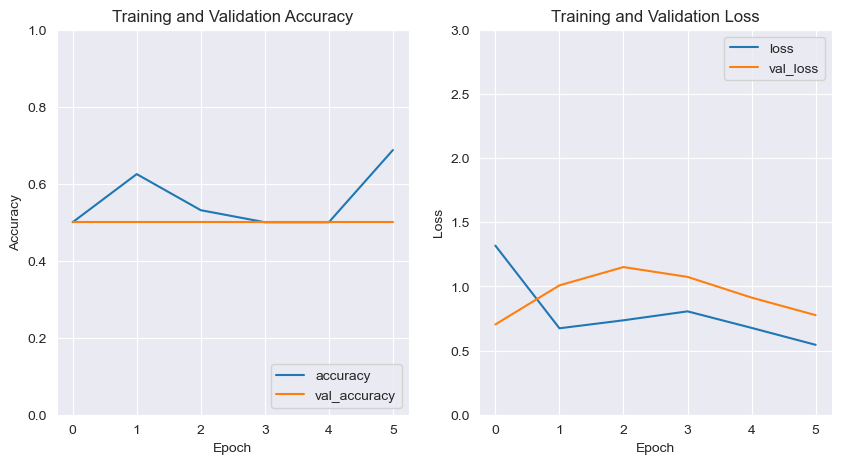

In [173]:
plot_training_history(train_hist)

In [174]:
# evaluate the model
test_loss, test_accuracy = conv_lstm.evaluate(test_gen)

1/1 ━━━━━━━━━━━━━━━━━━━━ 42s 42s/step - accuracy: 0.5000 - loss: 0.7017
